## Chapter 7
# Fourier Theorems for the DFT

## Signal Operators

### Flip Operator

We define the _flip operator_ by

$\text{Flip}_n(x) \triangleq x(-n)$,

for all sample indices $n \in \mathbb{Z}$. By modulo indexing, $x(-n)$ is the same as $x(N - n)$. The $\text{Flip}()$ operator reverses the order of samples $1$ through $N - 1$ of a sequence, leaving sample $0$ alone.

In [1]:
import numpy as np

In [2]:
def flip(x):
    return np.concatenate([[x[0]], x[-1:0:-1]])

In [3]:
flip(np.arange(5))

array([0, 4, 3, 2, 1])

### Shift Operator

The _shift operator_ is defined by

$\text{Shift}_{\Delta, n}(x) \triangleq x(n - \Delta), \Delta \in \mathbb{Z}$,

and $Shift_\Delta(x)$ denotes the entire shifted signal.

In [4]:
def shift(x, delta):
    return np.roll(x, delta)

## Convolution

The _convolution_ of two signals $x$ and $y$ in $\mathbb{C}^N$ may be denoted $x \circledast y$ and defined by

$(x \circledast y)_n \triangleq \sum_\limits{m=0}^\limits{N - 1}{x(m)y(n-m)}$.

In [5]:
def convolve(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    flipped_y = flip(y)
    convolved = np.zeros(x.size + y.size - 1)
    if x.dtype == complex or y.dtype == complex:
        convolved = convolved.astype(complex)
    for n in range(convolved.size):
        convolved[n] = np.sum(x * shift(flipped_y, n))
    return convolved

In [6]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from ipython_animation import create_animation, DEFAULT_FPS
%matplotlib inline

def plot_with_clipped_edges(x, y, **args):
    return plt.plot(np.concatenate([[x[0]], x, [x[-1]]]), np.concatenate([[0], y, [0]]), **args)

def create_convolution_animation(f, g, normalize=False, title='', length_seconds=3.5):
    f = np.asarray(f)
    g = np.asarray(g)
    x_max = len(f) * 5
    num_frames = x_max + len(g) + 1

    f = f / f.max()
    fig = plt.figure(figsize=(10.5, 2))
    plt.title(title)
    plt.axhline(color='black', linewidth=0.5)
    f_start = (x_max - len(f)) // 2
    f_line, = plot_with_clipped_edges(np.arange(len(f)) + f_start, f, c='b', label='$x$')
    g_line, = plot_with_clipped_edges(np.arange(-len(g), 0), g, c='r', label='$y$')
    convolution = convolve(f, g)
    if normalize:
        convolution = convolution / np.abs(convolution).max()
    revealed_convolution = np.full(len(convolution), np.nan)
    conv_line, = plt.plot(np.arange(len(convolution)) + (x_max - len(convolution)) / 2, revealed_convolution, label='$y = conv(x, y)$', linewidth=3)
    plt.axis([0, x_max, min(0, convolution.min(), f.min(), g.min()), max(1, convolution.max(), f.max(), g.max()) + 0.1])
    plt.legend(loc='upper right')

    def animate(i):
        g_data = g_line.get_xdata() + 1
        g_line.set_xdata(g_data) # step convolution to the right
        g_pos = g_data[0]
        if g_pos + len(g) >= f_start and g_pos < f_start + len(f):
            n_revealed = g_pos + len(g) - f_start
            revealed_convolution[:n_revealed] = convolution[:n_revealed]
        conv_line.set_ydata(revealed_convolution)
    return create_animation(fig, plt, animate, length_seconds=length_seconds, frames_per_second=num_frames/length_seconds)

#### Convolution Example 1: Smoothing a Rectangular Pulse

In [7]:
x = [0,0,0,0,1,1,1,1,1,1,0,0,0,0]
h = [1/3,1/3,1/3,0,0,0,0,0,0,0,0,0,0,0]
create_convolution_animation(x, h, title='Convolution: Smoothing a Rectangular Pulse')

#### Convolution Example 2: ADSR Envelope

In [8]:
x = [1.5] * 10 + [1] * 10 + [0] * 20
h = np.exp(-np.arange(40))
create_convolution_animation(x, h, title='Convolution: ADSR Envelope')

#### Convolution Example 3: Matched Filtering

In [9]:
x = [1,1,1,1,0,0,0,0]
h = flip(x)
create_convolution_animation(x, h, title='Convolution: Matched Filtering')

See my notebook for [Musimathics Ch4](https://nbviewer.jupyter.org/github/khiner/notebooks/blob/master/musimathics/volume_2/chapter_4_convolution.ipynb) for more animated examples of convolution. _(Note that the definition of convolution in this book is circular, whereas the implementation used in Musimathics is not. Thus the convolutions do not repeat in the Musimathics animations. **Also note** that the non-circular implementation is much more common. It is what numpy and scipy use, and it is the definition that makes the convolution Fourier theorems below hold.)_

### Stretch Operator

A _stretch by factor $L$_ is defined by

$\text{Stretch}_{L,m}(x) \triangleq \begin{cases}\begin{array}{ll}x(m/L), & m/L \space\text{an integer}\\0, & m/L \space\text{non-integer}\end{array}\end{cases}$.

In [10]:
def stretch(x, L):
    x = np.asarray(x)
    stretched = np.zeros(L * len(x))
    if x.dtype == complex:
        stretched = stretched.astype(complex)
    for m in range(stretched.size):
        if m % L == 0:
            stretched[m] = x[(m+1) // L]
    return stretched

In [11]:
stretch([4,1,2], 3)

array([ 4.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.])

The stretch operator describes _upsampling_ - increasing the sampling rate by an integer factor. A stretch by $K$ followed by lowpass filtering to the frequency band $\omega \in (-\pi/K,\pi/K)$ implements _ideal bandlimited interpolation_.

### Zero Padding

Definition:

$\text{ZeroPad}_{M,m}(x) \triangleq \begin{cases}\begin{array}{ll}x(m), & |m| < N/2 \space\text{an integer}\\0, & \space\text{otherwise}\end{array}\end{cases}$

In [12]:
def zero_pad(x, M):
    return np.insert(x, (len(x) + 1) // 2, np.zeros(M - len(x)))

In [13]:
zero_pad([1,2,3,4,5], 10)

array([1, 2, 3, 0, 0, 0, 0, 0, 4, 5])

In [14]:
zero_pad([1,2,3,0,0], 10)

array([1, 2, 3, 0, 0, 0, 0, 0, 0, 0])

### Repeat Operator

In [15]:
def repeat(x, L):
    return np.hstack([x] * L)

In [16]:
repeat([0,2,1,4,3,1], 2)

array([0, 2, 1, 4, 3, 1, 0, 2, 1, 4, 3, 1])

### Downsampling Operator

_Downsampling by $L$_ (also called _decimation_ by $L$) is defined for $x \in \mathbb{C}^N$ as taking every $L_{th}$ sample, starting with sample zero:

$\begin{align}
\text{Downsample}_{L,m}(x) &\triangleq x(mL),\\
m &= 0,1,2,...,M-1\\
N &= LM
\end{align}$.

In [17]:
def downsample(x, L):
    return x[::L]

In [18]:
downsample(np.arange(10), 2)

array([0, 2, 4, 6, 8])

### Alias Operator

The _aliasing operator_ for $N$-sample signals $x \in \mathbb{C}^N$ is defined by

$\begin{align}
\text{Alias}_{L,m}(x) &\triangleq \sum_\limits{l=0}^\limits{L-1}x(m + lM),\\
m &= 0,1,2,...,M-1\\
N &= LM
\end{align}$.

In [19]:
def alias(x, L):
    x = np.asarray(x)
    M = (x.size + 1) // L
    return x.reshape((L, M)).sum(axis=0)

In [20]:
x = np.arange(6)
alias(x, 2)

array([3, 5, 7])

In [21]:
alias(x, 3)

array([6, 9])

In [22]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,amssymb}']

def plot_signal_and_fft(signal=None, spectrum=None, spectrum_operator=None, show=[1,2,3,4], signal_label='$x$', spectrum_label=None):
    fft = np.fft.fft(signal) if spectrum is None else spectrum

    if spectrum_operator:
        fft = spectrum_operator(fft)

    num_plots = len(show)
    plot_number = 0

    if not spectrum_label:
        spectrum_label = signal_label.upper()

    plt.figure(figsize=(8, 2 * num_plots))
    if 1 in show and signal is not None:
        plot_number += 1
        plt.subplot(num_plots, 1, plot_number)
        plt.title(signal_label)
        if signal.dtype == complex:
            plt.plot(signal.real, c='orange', label='Real')
            plt.plot(signal.imag, c='purple', label='Imaginary')
            plt.legend()
        else:
            plt.plot(signal)
    
    if 2 in show:
        plot_number += 1
        plt.subplot(num_plots, 1, plot_number)
        plt.title(spectrum_label)
        plt.plot(np.abs(fft), c='r')
        plt.legend()

    if 3 in show:
        plot_number += 1
        plt.subplot(num_plots, 1, plot_number)
        plt.title(spectrum_label + ' Components')
        plt.plot(fft.real, c='orange', label='Real')
        plt.plot(fft.imag, c='purple', label='Imaginary')
        plt.legend()

    if 4 in show:
        plot_number += 1
        plt.subplot(num_plots, 1, plot_number)
        plt.title(spectrum_label + ' Phase')
        plt.plot(np.angle(fft), c='g')

    plt.tight_layout()
    return fft

# Fourier Theorems

In the next section, I will show empirically that all of the theorems listed in the book hold.

## Linearity

**Theorem:** For any $x, y \in \mathbb{C}^N$ and $\alpha, \beta \in \mathbb{C}$, the DFT satisfies

$\fbox{$\alpha x + \beta y \longleftrightarrow \alpha X + \beta Y$}$

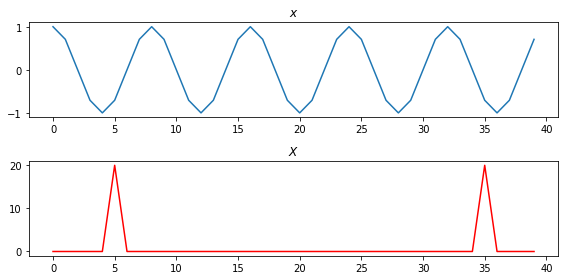

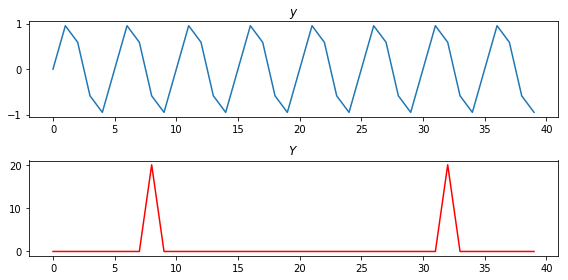

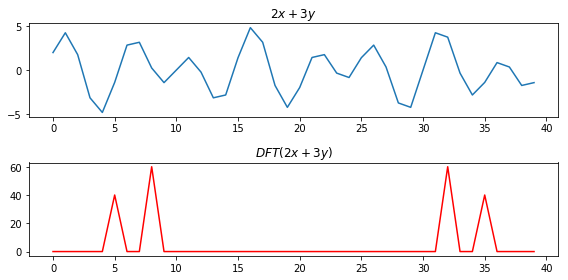

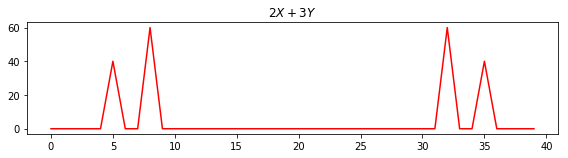

In [23]:
x = np.cos(np.linspace(-2 * np.pi, 2 * np.pi * 4, 40, endpoint=False))
y = np.sin(np.linspace(-2 * np.pi, 2 * np.pi * 7, 40, endpoint=False))

X = plot_signal_and_fft(x, show=[1,2], signal_label='$x$')
Y = plot_signal_and_fft(y, show=[1,2], signal_label='$y$')

_ = plot_signal_and_fft(2 * x + 3 * y, show=[1,2], signal_label='$2x + 3y$', spectrum_label='$DFT(2x + 3y)$')

_ = plot_signal_and_fft(spectrum=2 * X + 3 * Y, show=[1,2], signal_label='$2x + 3y$', spectrum_label='$2X + 3Y$')

### Conjugation and Reversal

**Theorem:** For any $x \in \mathbb{C}^N$,

$\fbox{$\overline{x} \longleftrightarrow $Flip$(\overline{X})$}.$

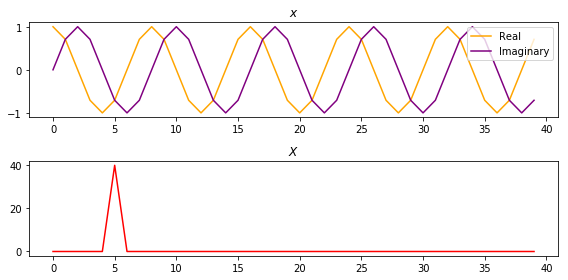

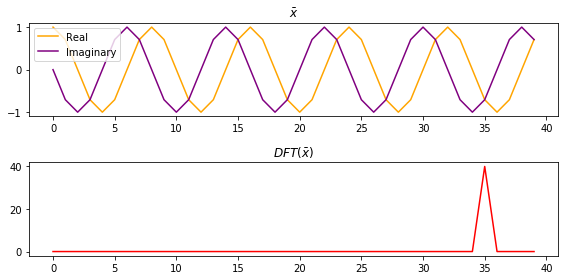

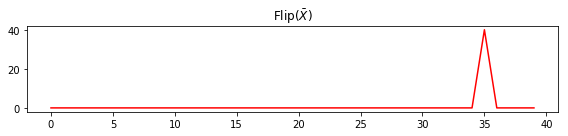

In [24]:
x = np.exp(1j * np.linspace(-2 * np.pi, 2 * np.pi * 4, 40, endpoint=False))

X = plot_signal_and_fft(x, show=[1,2])
_ = plot_signal_and_fft(np.conj(x), show=[1,2], signal_label='$\\bar{x}$', spectrum_label='$DFT(\\bar{x})$')
_ = plot_signal_and_fft(x, show=[2], spectrum_operator=lambda X: flip(np.conj(X)), spectrum_label='Flip$(\\bar{X})$')

**Theorem:** For any $x \in \mathbb{C}^N$,

$\fbox{Flip$(\overline{x}) \longleftrightarrow \overline{X}$}.$

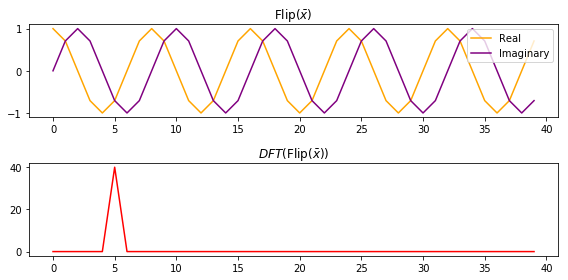

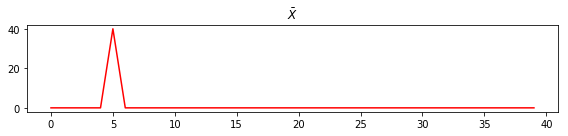

In [25]:
_ = plot_signal_and_fft(flip(np.conj(x)), show=[1,2], signal_label='Flip$(\\bar{x})$', spectrum_label='$DFT($Flip$(\\bar{x}))$')
_ = plot_signal_and_fft(spectrum=X, show=[2], spectrum_operator=np.conj, spectrum_label='$\\bar{X}$')

**Theorem:** For any $x \in \mathbb{C}^N$,

$\fbox{Flip$(x) \longleftrightarrow $ Flip$({X})$}.$

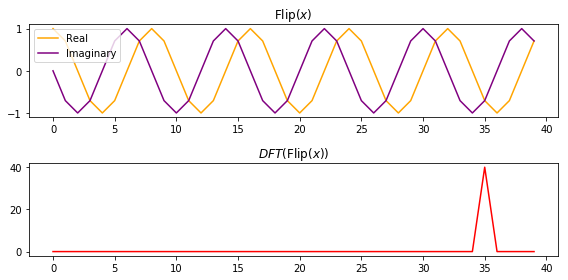

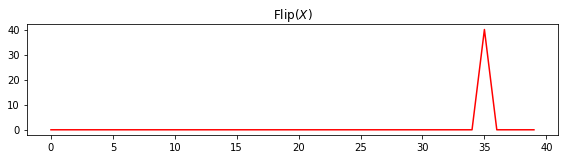

In [26]:
_ = plot_signal_and_fft(flip(x), show=[1,2], signal_label='Flip$(x)$', spectrum_label='$DFT($Flip$(x))$')
_ = plot_signal_and_fft(spectrum=flip(X), show=[1,2], spectrum_label='Flip$(X)$')

**Corollary:** For any $x \in \mathbb{R}^N$,

$\fbox{Flip$(x) \longleftrightarrow \overline{X}$}.$

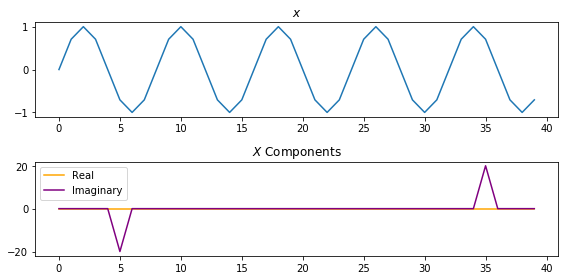

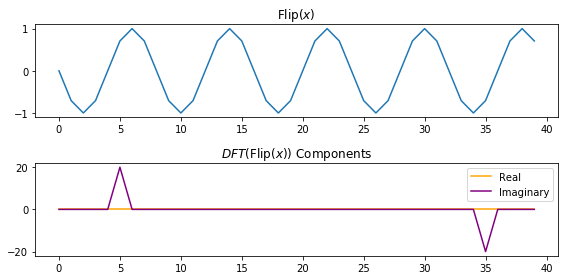

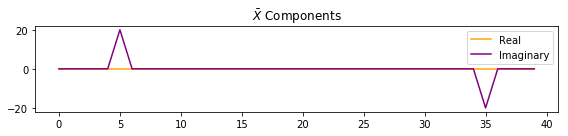

In [27]:
x = np.sin(np.linspace(-2 * np.pi, 2 * np.pi * 4, 40, endpoint=False))
X = plot_signal_and_fft(x, show=[1,3])
_ = plot_signal_and_fft(flip(x), show=[1,3], signal_label='Flip$(x)$', spectrum_label='$DFT($Flip$(x))$')
_ = plot_signal_and_fft(spectrum=np.conj(X), show=[3], spectrum_label='$\\bar{X}$')

**Corollary:** For any $x \in \mathbb{R}^N$,

$\fbox{Flip$(X) \longleftrightarrow \overline{X}$}.$

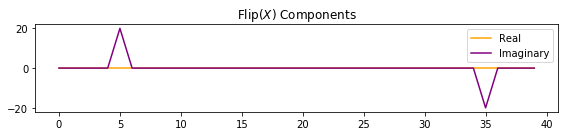

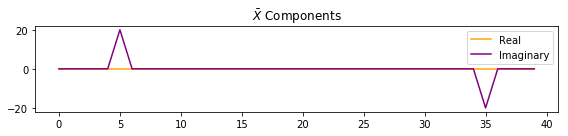

In [28]:
_ = plot_signal_and_fft(spectrum=flip(X), show=[3], spectrum_label='Flip$(X)$')
_ = plot_signal_and_fft(spectrum=np.conj(X), show=[3], spectrum_label='$\\bar{X}$')

### Shift Theorem

**Theorem:** For any $x \in \mathbb{C}^N$ and any integer $\Delta$,

$\fbox{DFT$_k[$Shift$_\Delta(X)] = e^{-j\omega_k\Delta}X(k)$}.$

The shift theorem is often expressed in shorthand as

$\fbox{$x(n-\Delta) \longleftrightarrow e^{-j\omega_k\Delta}X(\omega_k)$}.$

The shift theorem says that a _delay_ in the time domain corresponds to a _linear phase term_ in the frequency domain.

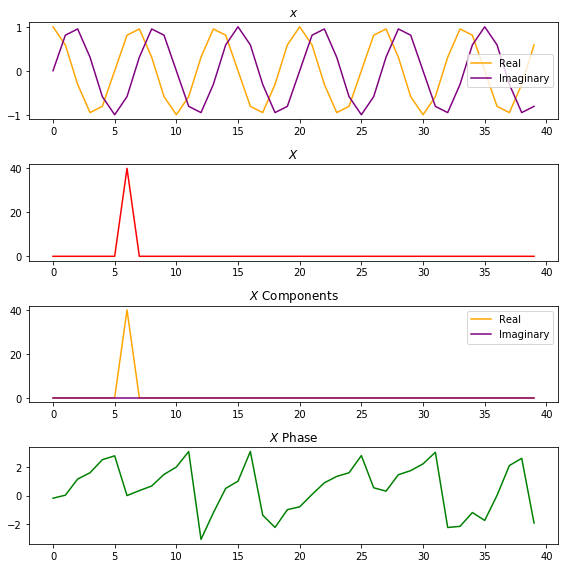

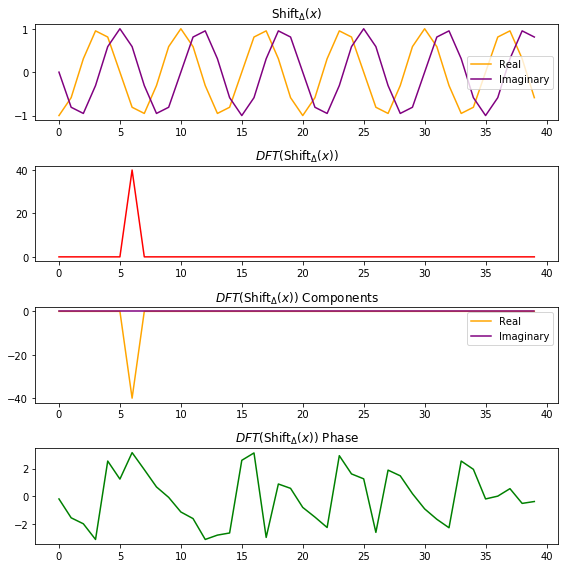

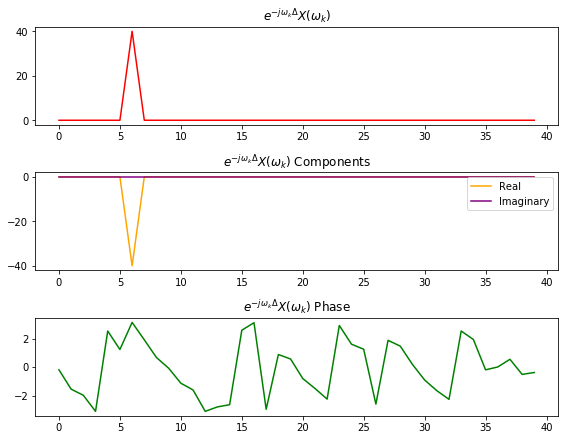

In [29]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 6, 40, endpoint=False))

delta = 10
X = plot_signal_and_fft(x)
_ = plot_signal_and_fft(shift(x, delta), signal_label='Shift$_\Delta(x)$', spectrum_label='$DFT($Shift$_\Delta(x))$')
_ = plot_signal_and_fft(spectrum=np.exp(-1j * 2 * np.pi * delta * np.arange(X.size) / X.size) * X, spectrum_label='$e^{-j\omega_k\Delta}X(\omega_k)$')

### Convolution Theorem

**Theorem:** For any $x,y \in \mathbb{C}^N$,

$\fbox{$x \circledast y \longleftrightarrow X \cdot Y$}.$

_(Note that we need to zero-pad the signals to the convolution-length before taking their spectra for this to hold, in order to avoid getting spectra corresponding to circular convolution)_.

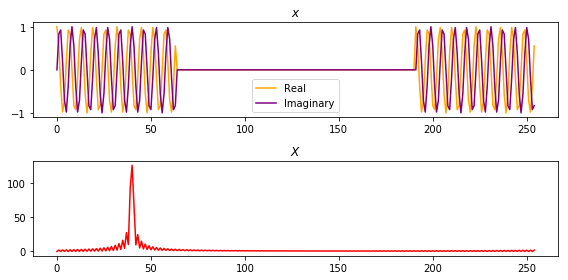

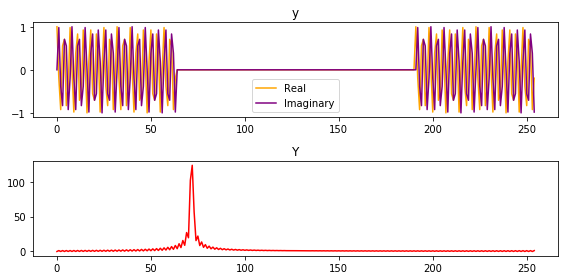

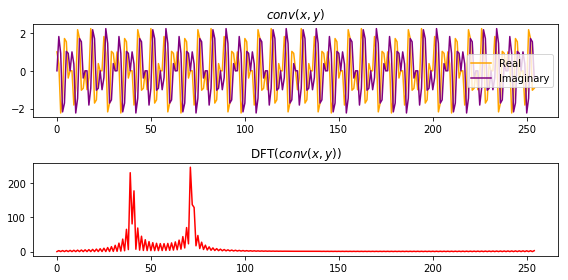

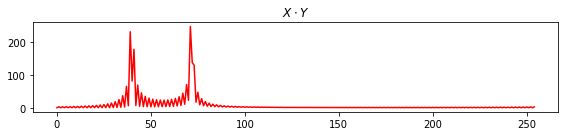

In [30]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 20, 128, endpoint=False))
y = np.exp(1j * np.linspace(0, 2 * np.pi * 36, 128, endpoint=False))

conv_size = x.size + y.size - 1

X = plot_signal_and_fft(zero_pad(x, conv_size), show=[1,2])
Y = plot_signal_and_fft(zero_pad(y, conv_size), show=[1,2], signal_label='y')
_ = plot_signal_and_fft(np.convolve(x, y), show=[1,2], signal_label='$conv(x, y)$', spectrum_label='DFT$(conv(x, y))$')
_ = plot_signal_and_fft(spectrum=X * Y, show=[2], spectrum_label='$X \\cdot Y$')

### Dual of the Convolution Theorem

The dual of the convolution theorem says that _multiplication in the time domain is convolution in the frequency domain_.

**Theorem:**

$\fbox{$x \cdot y \longleftrightarrow \frac{1}{N} X \circledast Y$}.$

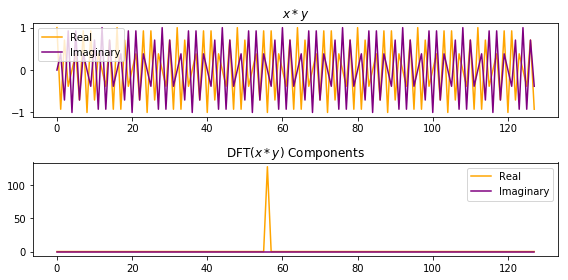

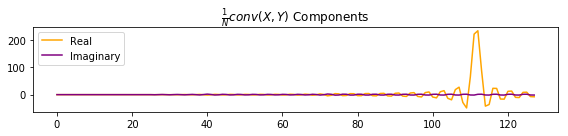

In [31]:
_ = plot_signal_and_fft(x * y, show=[1,3], signal_label = '$x * y$', spectrum_label='DFT$(x * y)$')
_ = plot_signal_and_fft(spectrum=np.convolve(X, Y)[:x.size] / x.size, show=[3], spectrum_label='$\\frac{1}{N}conv(X, Y)$')

### Power Theorem

**Theorem:** For all $x,y \in \mathbb{C}^N$,

$\fbox{$\langle x , y \rangle = \frac{1}{N}\langle X , Y \rangle$}.$

In [32]:
x = np.exp(1j * np.arange(100))
y = np.exp(1j * np.arange(100) * 2 * np.pi)
np.abs((x * np.conj(y)).sum())

0.54726924741583161

In [33]:
np.abs((np.fft.fft(x) * np.conj(np.fft.fft(y)))).sum() / x.size

0.54726924741635341

### Stretch Theorem (Repeat Theorem)

**Theorem:** For all $x \in \mathbb{C}^N$,

$\fbox{$\text{Stretch}_L(x) \longleftrightarrow \text{Repeat}_L(X)$}.$

That is, when you stretch a signal by the factor $L$ (inserting zeros between the original samples), its spectrum is repeated $L$ times around the unit circle.

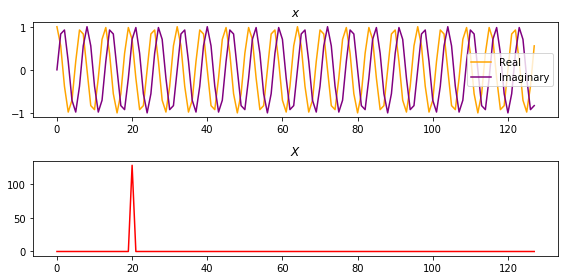

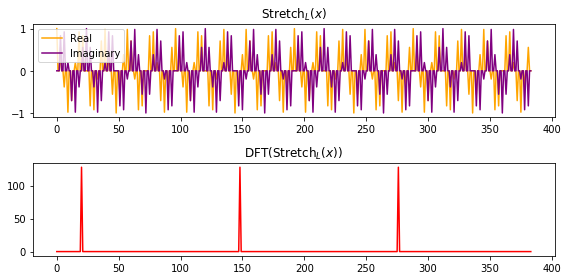

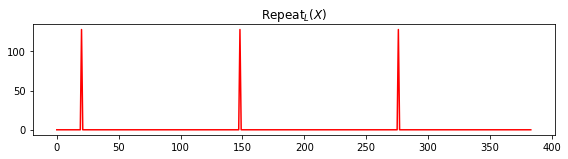

In [34]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 20, 128, endpoint=False))

L = 3
X = plot_signal_and_fft(x, show=[1,2])
_ = plot_signal_and_fft(stretch(x, L), show=[1,2], signal_label='Stretch$_L(x)$', spectrum_label='DFT(Stretch$_L(x)$)')
_ = plot_signal_and_fft(spectrum=repeat(X, L), show=[1,2], spectrum_label='Repeat$_L(X)$')

### Downsampling Theorem (Aliasing Theorem)

**Theorem:** For all $x \in \mathbb{C}^N$,

$\fbox{$\text{Downsample}_L(x) \longleftrightarrow \frac{1}{L}\text{Alias}_L(X)$}.$

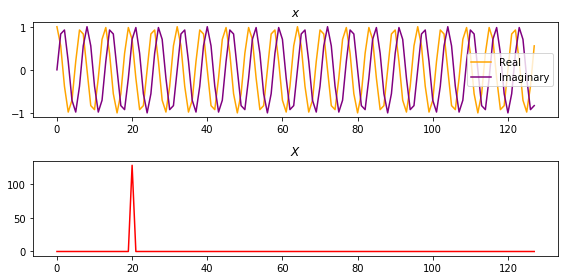

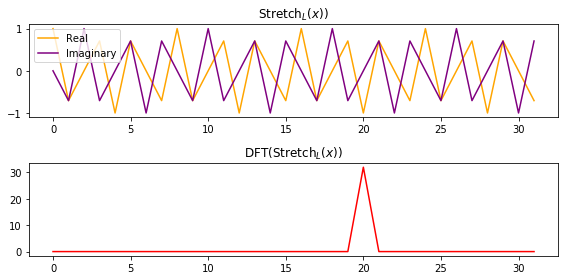

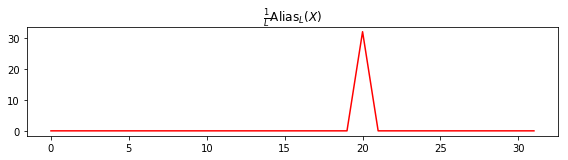

In [35]:
L = 4
X = plot_signal_and_fft(x, show=[1,2])
_ = plot_signal_and_fft(downsample(x, L), show=[1,2], signal_label='Stretch$_L(x)$)', spectrum_label='DFT(Stretch$_L(x)$)')
_ = plot_signal_and_fft(spectrum=alias(X, L) / L, show=[1,2], spectrum_label='$\\frac{1}{L}$Alias$_L(X)$')

### Zero Padding Theorem (Spectral Interpolation)

Zero padding in the time domain corresponds to _ideal interpolation in the frequency domain_ (for time-limited signals):

**Theorem:** For any $x \in \mathbb{C}^N$,

$\fbox{$\text{ZeroPad}_{LN}(x) \longleftrightarrow \text{Interp}_L(X)$}.$

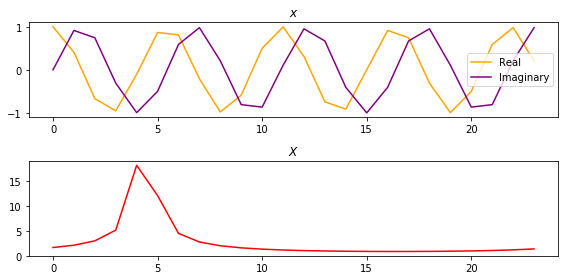

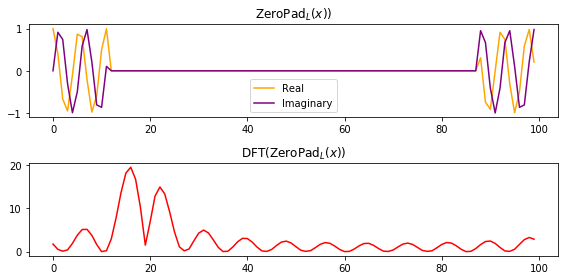

In [36]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 4.4, 24, endpoint=False))
X = plot_signal_and_fft(x, show=[1,2])
_ = plot_signal_and_fft(zero_pad(x, 100), show=[1,2], signal_label='ZeroPad$_L(x)$)', spectrum_label='DFT(ZeroPad$_L(x)$)')

### Periodic Interpolation (Spectral Zero Padding)

The dual of the zero-padding theorem states formally that _zero padding in the frequency domain_ corresponds to _periodic interpolation_ in the time domain:

**Definition:** For all $x \in \mathbb{C}^N$ and any integer $L \geq 1$,

$\fbox{$\text{PerInterp}_{L}(x) \triangleq \text{IDFT}(\text{ZeroPad}_{LN}(X))$}.$

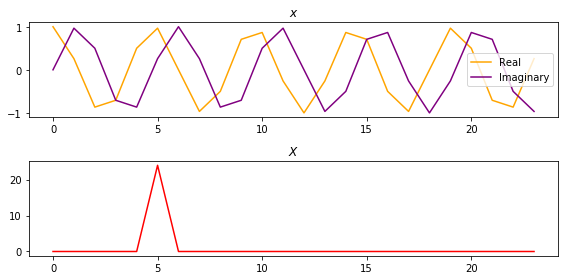

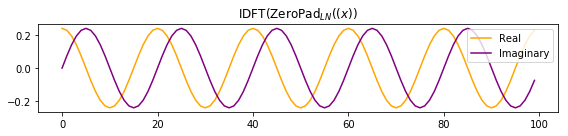

In [37]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 5, 24, endpoint=False))
X = plot_signal_and_fft(x, show=[1,2])
x_interp = np.fft.ifft(zero_pad(X, 100))
_ = plot_signal_and_fft(x_interp, show=[1], signal_label='IDFT(ZeroPad$_{LN}((x))$')

**Definition:** For any $X \in \mathbb{C}^N$ and any odd integer $M < N$ we define the _length M even rectangular windowing operation_ by

$\text{Chop}_{M,k}(X) \triangleq \begin{cases}\begin{array}{ll}X(k), & \space-\frac{M-1}{2} \leq k \leq \frac{M-1}{2}\\0, & \space\frac{M+1}{2} \leq \left|k\right| \leq \frac{N}{2}\end{array}\end{cases}$.

In [64]:
def chop(X, M):
    X_chopped = np.zeros(X.size).astype(complex)
    X_chopped[-(M - 1) // 2:] = X[-(M - 1) // 2:]
    X_chopped[:(M - 1) // 2] = X[:(M - 1) // 2]
    return X_chopped

**Theorem:** When $x \in \mathbb{C}^N$ consists of one or more periods from a _periodic_ signal $x^\prime \in \mathbb{C}^\infty$,

$\fbox{$\text{PerInterp}_{L}(x) \longleftrightarrow \text{IDFT}(\text{Chop}_N(\text{DFT}(\text{Stretch}_L(x))))$}.$

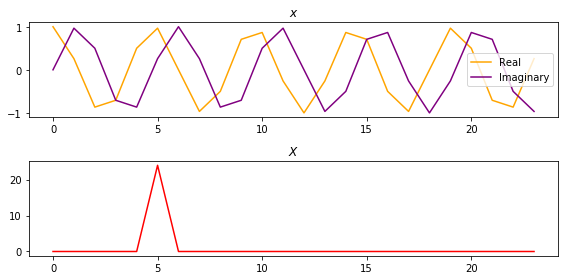

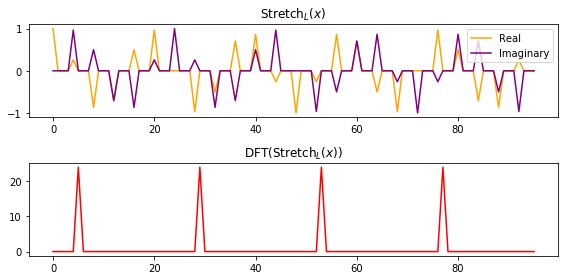

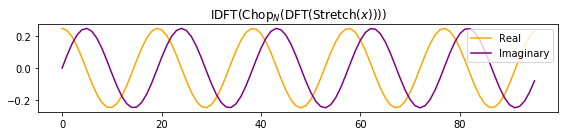

In [70]:
x = np.exp(1j * np.linspace(0, 2 * np.pi * 5, 24, endpoint=False))
X = plot_signal_and_fft(x, show=[1,2])

L = 4
x_stretch = stretch(x, L)
X_stretch = plot_signal_and_fft(x_stretch, show=[1,2], signal_label='Stretch$_L(x)$', spectrum_label='DFT(Stretch$_L(x)$)')

x_interp = np.fft.ifft(chop(X_stretch, x.size))
_ = plot_signal_and_fft(x_interp, show=[1], signal_label='IDFT(Chop$_{N}($DFT$($Stretch$(x))))$')

## DFT Theorem Problems

**1. The notation**

$x = y(\mod N)$

**(which is read "$x$ equals $y$ modulo $N$"), means there exists some integer $k$ such that $x = y + kN$. Similarly, the notation "$x\mod N$" means $x + kN$ with $k$ chosen to give a result between $0$ and $N - 1$. In the problems below, find $k \in \mathbb{Z}$ for each case:**

**a) $N = 0(\mod N)$**  
**b) $-1 = (N - 1)(\mod N)$**  
**c) $X / 2 = y(\mod N) \leftrightarrow X = 2Y(\mod 2N)$**  

a) $N = 0(\mod)N \implies N = 0 + kN \implies k = 1$

b) $-1 = (N - 1)(\mod N) \implies -1 = (N-1) + kN \implies k = \frac{-1 - (N - 1)}{N} \implies k = -1$

c) $X = 2Y(\mod 2N) \implies X = 2Y + 2kN \implies kN = \frac{X - 2Y}{2} = \frac{X}{2} - Y$

Man I wish I could find a solution manual. JOS is looking for an integer solution, and all I see here is a relationship of 3 unknowns. I don't know what he's getting at. :(

**2. Show that when $N$ is even, the DFT summation can be split into two sums over the odd and even indices of the input signal to obtain**

$X(\omega_k) = \text{DFT}_{\frac{N}{2},k}\{\text{Downsample}_2(x)\} + W_N^k\cdot \text{DFT}_{\frac{N}{2},k}\{\text{Downsample}_2\left[\text{Shift}_1(x)\right]\}$

In other words, a length $N$ DFT can be computed using two length $N/2$ DFTs. The splitting into sums over even and odd time indices is called _decimation in time_.

$\begin{align}
X(\omega_k) &= \sum_\limits{n=0}^\limits{N - 1}x(n)e^{-j2\pi k n/N}\\
&= \sum_\limits{n=0}^\limits{\frac{N}{2} - 1}x(2n)e^{-j2\pi k (2n)/N} + \sum_\limits{n=0}^\limits{\frac{N}{2} - 1}x(2n + 1)e^{-j2\pi k (2n + 1)/N}\\
&= \sum_\limits{n=0}^\limits{\frac{N}{2} - 1}x(2n)e^{-j2\pi k (2n)/N} + \sum_\limits{m=2}^\limits{\frac{N}{2} - 1}x(m - 1)e^{-j2\pi k (m - 1)/N}, \space\space(m \triangleq 2n+2)\\
&= \sum_\limits{n=0}^\limits{\frac{N}{2} - 1}x(2n)e^{-j2\pi k (2n)/N} + \sum_\limits{m=2}^\limits{\frac{N}{2} - 1}x(m - 1)e^{-j2\pi k m/N}e^{j2\pi k/n}\\
&= \sum_\limits{n=0}^\limits{\frac{N}{2} - 1}x(2n)e^{-j2\pi k (2n)/N} + W_N^k\sum_\limits{m=2}^\limits{\frac{N}{2} - 1}x(m - 1)e^{-j2\pi k m/N}\\
&= \text{DFT}_{\frac{N}{2},k}\{\text{Downsample}_2(x)\} + W_N^k\sum_\limits{m=2}^\limits{\frac{N}{2} - 1}\text{Shift}_{1, m}(x)e^{-j2\pi k m/N}\\
&= \text{DFT}_{\frac{N}{2},k}\{\text{Downsample}_2(x)\} + W_N^k\cdot \text{DFT}_{\frac{N}{2},k}\{\text{Downsample}_2\left[\text{Shift}_1(x)\right]\}
\end{align}$



**3. Show that $\text{DFT}(\text{DFT}(y)) = N\cdot \text{Flip}(y)$, where $\text{Flip}_n(y) \triangleq y[-n] = y[N-n]$.**

$\begin{align}
\text{DFT}_k(\text{DFT}_k(y)) &= \text{DFT}_k(\sum_\limits{n=0}^\limits{N - k}y(n)e^{-j2\pi k n/N})\\
&= \sum_\limits{n=0}^\limits{N - 1}e^{-j2\pi k n/N}\left[\sum_\limits{m=0}^\limits{N - 1}y(m)e^{-j2\pi k m/N}\right]\\
&=\sum_\limits{k=0}^\limits{N-1}Y(-k)e^{j2\pi n(-k)/N}\\
&= N\cdot \text{IDFT}_k(\text{Flip}_k(Y))\\
&= N\cdot \text{Flip}_n(y)\\
\end{align}$


**4. Show that every signal $x[n], n = 0,1,...,N-1$, can be uniquely expressed as $x[n] = x_e[n] + x_o[n]$, where $x_e$ is even and $x_o$ is odd.**

Consider any element $x[n]$ of signal $x$ of length $N$.  Then we must find values $x_e and x_o$ that satisfy the following:

$x[n] = x_e[n] + x_o[n]$  
$x_e[n] = x_e[-n] \triangleq x_e[N - n]$  
$x_o[n] = -x_o[-n] \triangleq -x_o[N - n]$

The first constraint can equivalently be stated as

$\begin{align}
x[N - n] &= x_e[N - n] + x_o[N - n]\\
&= x_e[n] - x_o[n]\space\space\text{(using the constraints for $x_e[n]$ and $x_o[n]$ above)}
\end{align}$.

Now we can solve for $x_e[n]$ and $x_o[n]$:

$x_e[n] = x[n] - (x_e[n] - x[N - n]) \implies x_e[n] = \frac{x[n] + x[N - n]}{2}$  
$x_o[n] = x[n] - x_e[n] \implies x_o[n] = \frac{x[n] - x[N - n]}{2}$  

$QED$

Let's try this on a simple example to convince ourselves it works:

Consider $x \triangleq [1,2,3,4]$.  Then

$\begin{align}x_e &= [\frac{x[0] + x[N - 0]}{2}, \frac{x[1] + x[N - 1]}{2}, \frac{x[2] + x[N - 2]}{2}, \frac{x[3] + x[N - 3]}{2}]\\
&=  [\frac{1+4}{2}, \frac{2+3}{2}, \frac{3+2}{2}, \frac{4+1}{2}]\\
&= [\frac{5}{2},\frac{5}{2},\frac{5}{2},\frac{5}{2}]\\
\end{align}$

$\begin{align}x_o &= [\frac{x[0] - x[N - 0]}{2}, \frac{x[1] - x[N - 1]}{2}, \frac{x[2] - x[N - 2]}{2}, \frac{x[3] - x[N - 3]}{2}]\\
&=  [\frac{1-4}{2}, \frac{2-3}{2}, \frac{3-2}{2}, \frac{4-1}{2}]\\
&= [\frac{-3}{2},\frac{-1}{2},\frac{1}{2},\frac{3}{2}]\\
\end{align}$

$\begin{align}x &= [x_e[0] + x_o[0], x_e[1] + x_o[1], x_e[2] + x_o[2], x_e[3] + x_o[3]]\\
&= [\frac{5}{2}+\frac{-3}{2},\frac{5}{2}+\frac{-1}{2},\frac{5}{2}+\frac{1}{2},\frac{5}{2}+\frac{3}{2}]\\
&= [1,2,3,4]
\end{align}$


**5. Find the even and odd parts of the following sequences:**

**a) $[0,1,2,1]$**

$x_e = [0.5, 1.5, 1.5, 0.5]$  
$x_o = [-0.5, -0.5, 0.5, 0.5]$

**b) $[0,1,0,-1]$**

$x_e = [-0.5, 0.5, 0.5, -0.5]$  
$x_o = [0.5, 0.5, -0.5, -0.5]$

**c) $[0,1,2,3]$**

$x_e = [1.5, 1.5, 1.5, 1.5]$  
$x_o = [-1.5, -0.5, 0.5, 1.5]$

**d) $[0,0,0,0]$**

$x_e = [0,0,0,0]$  
$x_o = [0,0,0,0]$

**e) $x[n] = n^2, n = 0,1,...,N-1$**

$x_e[n] = \frac{x[n] + x[N - n]}{2} = \frac{n^2 + (N - n)^2}{2} = \frac{n^2 + N^2 - 2n + n^2}{2} = \frac{N^2 + 2n^2 - 2n}{2} = \frac{N^2}{2} + n(n - 1)$  
$x_o[n] = \frac{x[n] - x[N - n]}{2} = \frac{n^2 - (N - n)^2}{2} = \frac{n^2 - N^2 + 2n - n^2}{2} = \frac{-N^2 + 2n}{2} = \frac{-N^2}{2} + n$  

In [71]:
# verify:
N = 10
x = np.arange(N) ** 2
x_e = np.arange(N)*(np.arange(N) - 1) # -N^2/2 terms cancel.
x_o = np.arange(N)
x

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [72]:
x_e + x_o

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

**6. A spectrum $X[k]$ is said to be _Hermitian_ if $X[-k] = X^*[k]$, i.e., its real part is _even_ and its imaginary part is _odd_. Given a Hermitian spectrum, what are the symmetry properties of its magnitude and phase?**

As discussed on page 147, the magnitude of the spectrum of a _real_ signal is even, and its phase is odd.  Since a real signal has a Hermitian spectrum, a Hermetian spectrum has even magnitude and odd phase.

**7. If $Y[k]$ denotes the $k_{th}$ element of the length $N$ DFT of $y$, show that:**

**a) $\text{im}\{y\} = 0 \longleftrightarrow Y[k] = \overline{Y[N-k]}$ [DFT{real} is _Hermetian]**



$\begin{array}{ll}
Y[k] &\triangleq \sum_\limits{n=0}^{N-1}y(n)e^{-j\omega_kn}\\
&= \sum_\limits{n=0}^{N-1}\left[y_r(n) + jy_i(n)\right]\cos(\omega_kn) - j\left[y_r(n) + jy_i(n)\right]\sin(\omega_kn)\\
&= \sum_\limits{n=0}^{N-1}y_r(n)\cos(\omega_kn) - jy_r(n)\sin(\omega_kn) &\text{since $y_i = 0$}\\
&= \sum_\limits{n=0}^{N-1}y_r(n)\cos(-\omega_kn) + jy_r(n)\sin(-\omega_kn) &\text{since cos is even and sin is odd}\\
&= \overline{\sum_\limits{n=0}^{N-1}y_r(n)\cos(-\omega_kn) - jy_r(n)\sin(-\omega_kn)}\\
&= \overline{\sum_\limits{n=0}^{N-1}y(n)e^{-j2\pi(-k)/N}}\\
&= \overline{Y[-k]}\\
&= \overline{Y[N - k]}
\end{array}$

**b) $\text{re}\{y\} = 0 \longleftrightarrow Y[k] = -\overline{Y[N-k]}$ [_anti-Hermitian_]**

$\begin{array}{ll}
Y[k] &\triangleq \sum_\limits{n=0}^{N-1}y(n)e^{-j\omega_kn}\\
&= \sum_\limits{n=0}^{N-1}\left[y_r(n) + jy_i(n)\right]\cos(\omega_kn) - j\left[y_r(n) + jy_i(n)\right]\sin(\omega_kn)\\
&= \sum_\limits{n=0}^{N-1}jy_i(n)\cos(\omega_kn) - j\left[jy_i(n)\right]\sin(\omega_kn) &\text{since $y_r = 0$}\\
&= \sum_\limits{n=0}^{N-1}jy_i(n)\cos(-\omega_kn) + j\left[jy_i(n)\right]\sin(-\omega_kn) &\text{since cos is even and sin is odd}\\
&= \overline{\sum_\limits{n=0}^{N-1}\left[jy_i(n)\cos(-\omega_kn) - jy_i(n)\sin(-\omega_kn)\right]}\\
&= -\overline{\sum_\limits{n=0}^{N-1}jy_i(n)e^{-j2\pi(-k)/N}}\\
&= -\overline{\sum_\limits{n=0}^{N-1}y(n)e^{-j2\pi(-k)/N}}\\
&= -\overline{Y[-k]}\\
&= -\overline{Y[N - k]}
\end{array}$

TODO not quite there

**c) $y$ even $\longleftrightarrow Y$ even**

$\begin{align}
X(k) &\triangleq \sum_\limits{n=0}^\limits{N-1}x(n)e^{-j\omega_kn}\\
&= \sum_\limits{n=0}^\limits{N-1}x(n)\cos(\omega_kn) - j\sum_\limits{n=0}^\limits{N-1}x(n)\sin(\omega_kn)\\
&= \sum_n \text{even}_n \cdot \text{even}_{nk} - j\sum_n \text{even}_n \cdot \text{odd}_{nk}\\
&= \sum_n \text{even}_n \cdot \text{even}_{nk} - 0\\
&= \text{even}_{k}
\end{align}$

**d) $y$ odd $\longleftrightarrow Y$ odd**

$\begin{align}
X(k) &\triangleq \sum_\limits{n=0}^\limits{N-1}x(n)e^{-j\omega_kn}\\
&= \sum_\limits{n=0}^\limits{N-1}x(n)\cos(\omega_kn) - j\sum_\limits{n=0}^\limits{N-1}x(n)\sin(\omega_kn)\\
&= \sum_n \text{odd}_n \cdot \text{even}_{nk} - j\sum_n \text{odd}_n \cdot \text{odd}_{nk}\\
&= 0 - j\sum_n \text{odd}_n \cdot \text{odd}_{nk}\\
&= -j\cdot\text{odd}_{k}\\
&= \text{odd}_{k}
\end{align}$

**e) $y$ real, even $\longleftrightarrow Y$ real, even**

See solution for **c** above, and notice that the only $j$ component sums out. Thus, the result could only be imaginary if either $y$ or $\cos(\omega_kn)$ had an imaginary component. Since we're given that $y$ is real, and $\cos(\omega_kn)$ has no imaginary component, we are done.

**f) $y$ real, odd $\longleftrightarrow Y$ imag, odd**

See solution for **d** above, and notice that the only (odd) component remaining is a multiple of $j$. Thus, the result could only be real if $y$ was imaginary (cancelling the imaginary components in the multiplication).  Since we're given that $y$ is real, we are done.

**g) $y$ imag, even $\longleftrightarrow Y$ imag, even**

See solution for **c** above, and notice that the remaining summed components on the second to last line are $y(n)$ and $\cos(\omega_kn)$. Since we're given that $y$ is imaginary, and since $cos(\omega_kn)$ has no imaginary component, we have $\sum_n \text{imaginary} \cdot \text{real} = \sum_n \text{imaginary}$.

**h) $y$ imag, odd $\longleftrightarrow Y$ real, odd**

See solution for **d** above, and notice that the only (odd) component remaining is a multiple of $j$. Thus, the result could only be imaginary if $y$ was real (cancelling the imaginary components in the multiplication).  Since we're given that $y$ is imaginary, we are done.

**8) Let $y = [0,j,2,3]$. Find**

**a) $\text{DFT}_k(y)$**

$\begin{align}
\text{DFT}_k(y) &= \sum_\limits{n=0}^\limits{N - 1}y(n)e^{-j2\pi kn/N}\\
&=0\cdot 1 + j \cdot e^{-j2\pi k/4} + 2e^{-j2\pi 2k/4} + 3e^{-j2\pi 3k/4}\\
&=j \cdot e^{-j\pi k/2} + 2e^{-j\pi k} + 3e^{-j\pi 3k/2}\\
\end{align}$

**b) $\text{DFT}_k(\text{DFT}(y))$**

$\begin{align}
\text{DFT}(y) &= [\text{DFT}_0(y),\text{DFT}_1(y),\text{DFT}_2(y),\text{DFT}_3(y)]\\
&=0\cdot 1 + j \cdot e^{-j2\pi k/4} + 2e^{-j2\pi k/2} + 3e^{-j2\pi 3k/4}\\
&= [5+j, -1+3j,-1-1j,-3-3j]
\end{align}$

$\begin{align}
\text{DFT}_k(\text{DFT}(y)) &= \text{DFT}_k([5+j, -1+3j,-1-1j,-3-3j])\\
&=(5+j) + (-1+3j) \cdot e^{-j\pi k/2} + (-1-1j) \cdot e^{-j\pi k} + (-3-3j) \cdot e^{-j\pi 3k/2}\\
\end{align}$


**c) $\text{DFT}_k(\text{DFT}(y + \frac{1}{2}\text{Flip}(y)))$**

$\begin{align}
\text{DFT}_k(\text{DFT}(y + \frac{1}{2}\text{Flip}(y))) &= \text{DFT}_k(\text{DFT}(y) + \text{DFT}(\frac{1}{2}\text{Flip}(y)))\\
&= \text{DFT}_k(Y + \frac{1}{2}\text{Flip}(Y))\\
&= \text{DFT}_k([5+j,-1+3j,-1-1j,-3-3j] + \frac{1}{2}[-3-3j,-1-1j,-1+3j,5+j])\\
&= \text{DFT}_k([2-2j,-2+2j,-2+2j,2-2j])\\
&=(2-2j) + (-2+2j) \cdot e^{-j2\pi k/4} + (-2+2j) \cdot e^{-j2\pi k/2} + (2-2j) \cdot e^{-j2\pi 3k/4}\\
\end{align}$

**d) $\text{DFT}_k(y + \overline{y})$**

$\begin{align}
\text{DFT}_k(y + \overline{y}) &=  \text{DFT}_k([0,j,2,3] + [0,-j,2,3])\\
&= \text{DFT}_k([0,0,4,6])\\
&= 4e^{-j\pi k} + 6e^{-j\pi 3k/2}\\
\end{align}$

**e) $\text{DFT}_k(\text{re}\{y\})$**

$\begin{align}
\text{DFT}_k(\text{re}\{y\}) &=  \text{DFT}_k([0,0,2,3])\\
&= 2e^{-j\pi k} + 3e^{-j\pi 3k/2}
\end{align}$

**f) $\text{DFT}_k([0,j,2,3,0,0,0,0])$ [How is the answer related to (a)?]**

Each of the exponentials in **(a)** will be raised to the power of $\frac{1}{2}$ (since $N = 8 = \text{len}(y) * 2$).  Geometrically, the result will travel around the unit circle half as fast.

**g) $\text{DFT}_k([1,j,2,3,0,0,0,0])$ [This should be easy.]**

$\begin{align}
\text{DFT}_k([1,j,2,3,0,0,0,0]) &= 1 + j \cdot e^{-j2\pi k/8} + 2e^{-j2\pi 2k/8} + 3e^{-j2\pi 3k/8}\\
&= 1 + j \cdot e^{-j\pi k/4} + 2e^{-j\pi k/2} + 3e^{-j\pi 3k/4}\\
\end{align}$

**h) $\text{DFT}_k([0,1,0,0])$**

$\begin{align}
\text{DFT}_k([0,1,0,0]) &= e^{-j\pi k/2}\\
\end{align}$

**i) $\text{DFT}_k([3,0,j,2]) = \text{DFT}_k(\text{Shift}_1(y))$**

From the Shift Theorem,

$\begin{align}
\text{DFT}_k(\text{Shift}_1(y)) &= e^{-j\omega_k\cdot 1} Y_k\\
&=e^{-j\pi k/2} \left[j \cdot e^{-j\pi k/2} + 2e^{-j\pi k} + 3e^{-j\pi 3k/2}\right]\\
&=j \cdot e^{-j\pi k} + 2e^{-j\pi 3k/2} + 3e^{-2j\pi k}\\
\end{align}$

**j) $\text{DFT}_k([j,3]) = \text{DFT}_k(\text{Downsample}_2(y))$**

$\begin{align}
\text{DFT}_k([j,3]) &=j + 3e^{-j\pi k}\\
\end{align}$

**k) $\text{DFT}_k([0,0,j,0,2,0,3,0]) = \text{DFT}_k(\text{Stretch}_2(y))$**

Since

$\text{DFT}(\text{Stretch}_L(y)) = \text{Repeat}_L(Y)$,

$\text{DFT}_k(\text{Stretch}_2(y)) = \text{DFT}_k(Y)$, with modulo indexing. ($\text{DFT}_{k\text{mod}2}(Y)$)

**l) $\text{DFT}_k(x), x[n] = \cos\left[2\pi n/8\right], n=0,1,...,7$**

$\begin{align}
\text{DFT}_k(\cos\left[2\pi n/8\right]) &= \sum_\limits{n=0}^\limits{7}\cos\left[2\pi n/8\right]e^{-j2\pi kn/8}\\
&= \sum_\limits{n=0}^\limits{7}\cos\left[2\pi n/8\right]e^{-j2\pi kn/8}\\
&= \sum_\limits{n=0}^\limits{7}\cos(2\pi n/8)\left[\cos(2\pi kn/8) - j\sin(2\pi kn/8)\right]\\
&= \sum_\limits{n=0}^\limits{7}\cos(2\pi n/8)\cos(2\pi kn/8) - j\cos(2\pi n/8)\sin(2\pi kn/8)\\
&= \sum_\limits{n=0}^\limits{7}\cos(2\pi n/8)\cos(2\pi kn/8) - j\sum_\limits{n=0}^\limits{7}\text{even} \cdot \text{odd}\\
&= \sum_\limits{n=0}^\limits{7}\cos(2\pi n/8)\cos(2\pi kn/8)\\
\end{align}$
